# Discussion Hotness 2020-06-28

Several people have pointed out the robotic "nice job!" posts in the [1st Place Removed Solution - All Faces Are Real Team](https://www.kaggle.com/c/deepfake-detection-challenge/discussion/157983) thread...

Perhaps these users/bots are defaulting to clicking on the *Hottest* topic. I noticed that post has been *Hottest* for over two weeks now:

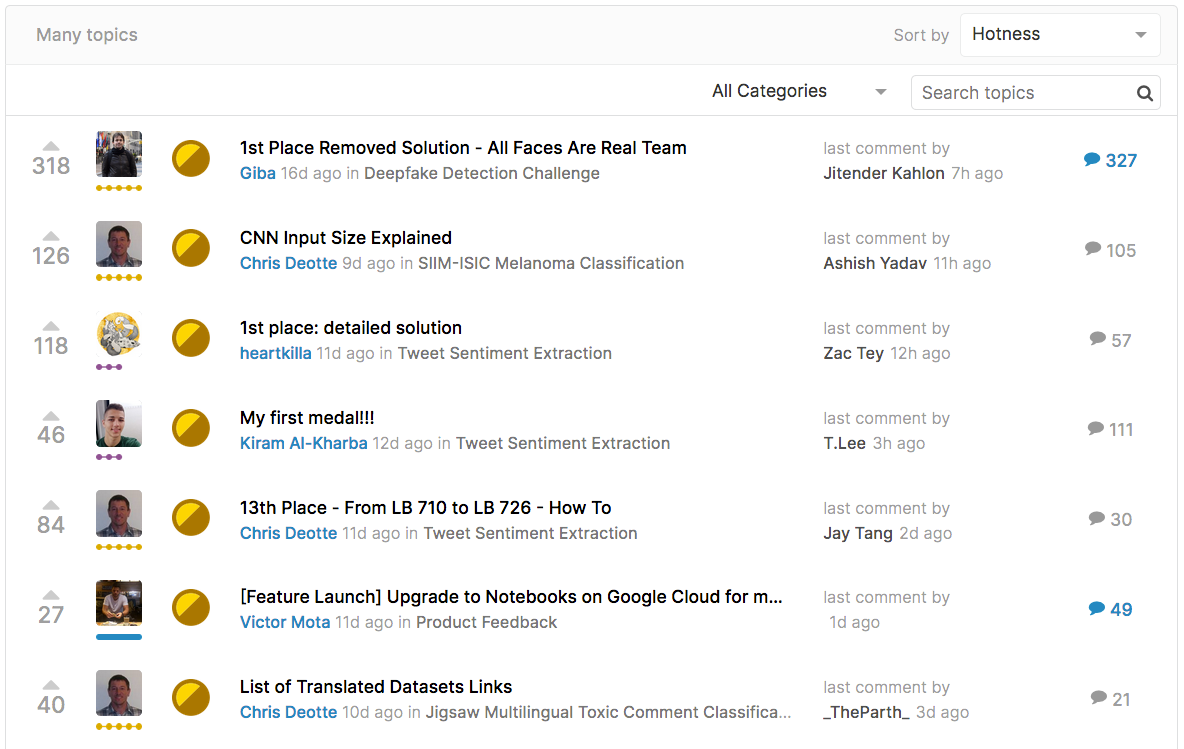

It reminded me of this [bug post "Discussion Hotness Frozen?"](https://www.kaggle.com/product-feedback/119431).

Looking closer - the bug is back, discussion *Hotness* is indeed frozen again and has been for over a week. (In fact I've seen it other times too.)

I scraped the listings and made some plots and they looked so striking I thought I'd share them. They tell you at once the nature of the failure, and that the fallback system just queues posts, perhaps using the post ID (ascending numerically) to rank.

# Data

Data is collected in [this Notebook](https://www.kaggle.com/jtrotman/scrape-discussion-hotness) from the global discussion index: https://www.kaggle.com/discussion

The first 500 pages are scraped. Each has 20 discussion posts, so the current *Hottest* 10k posts are here. The dataframe is in *Hotness* order, recorded by the index, and a *Page* column marks the source page.

The *Hotness* ordering in each competition forum appears to be the same order as in the global discussion listing, so it is possible to filter on `parentName` to see a sub-listing.

# How Should It Work?

Great example in *Probabilistic Programming & Bayesian Methods for Hackers* [here under "How to order Reddit submissions"](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter4_TheGreatestTheoremNeverTold/Ch4_LawOfLargeNumbers_PyMC3.ipynb#Example:-How-to-order-Reddit-submissions)

New posts should appear high up for a time and then sink or swim based on vote/comment counts.

In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import gc, os, sys, re, time
import pandas as pd
import numpy as np

dates = [
    'postDate',
    'lastCommentPostDate',
]

In [2]:
filepath = '../input/discussion-hotness-2020-06-28/discussion-hotness-2020-06-28.csv'

In [3]:
df = pd.read_csv(filepath, parse_dates=dates, index_col=0)
df.shape

In [4]:
df.authorType.value_counts()

add 1 minute to last seen post date and compute age based on that

In [5]:
latest = df.postDate.max() + pd.Timedelta(1, 'm')

In [6]:
df['Age'] = ((latest - df.postDate) / pd.Timedelta(1, 'd')).astype('float32')

In [7]:
# for plot.ly
df['postDateText'] = df.postDate.dt.strftime("%c")
df['lastCommentPostDateText'] = df.lastCommentPostDate.dt.strftime("%c")

In [8]:
df['VotesPerDay'] = df['votes'] / df['Age']
df['VotesPerComment'] = df['votes'] / df['commentCount']
df['CommentsPerDay'] = df['commentCount'] / df['Age']

# Overview of DataFrame

In [9]:
df.describe(include='all').T

In [10]:
plt.rc("figure", figsize=(14, 9))
plt.rc("font", size=(14))

title = "Discussion Posts Hotness"
params = dict(title=title, alpha=0.4)

# Main Trend

## Newer Posts on Earlier Pages

The overall trend is clear - newer posts appear on earlier pages, but for the first 70 pages or so (`70*20 = 1400` topics) the trend is **reversed**: newer posts appear further down like they are joining a queue.


In [11]:
df.plot.scatter('Page', 'Age', **params)

# Zoom In

## Nothing from the past week appears on page 1-8 of Hotness!

And after page 8 or so posts are listed in time order, newer posts just debut further down and have stayed there. No initial *Hotness* and no upward mobility.

The new posts entering on the left are in fact pushing in infront of the cluster on the right. The messages at the bottom/left of that second cluster have all been posted at a really unfortunate time, they are sliding down the rankings despite getting votes & comments. Not being smoothly mixed in like they normally would.

In [12]:
df.query("Page<=80").plot.scatter('Page', 'Age', **params)

# Plot.ly Interactive Plot

Hover over points for details; drag to zoom in on areas - perhaps we can see when the fault started.

In [13]:
hover_data = [
    'Page', 'commentCount', 'id', 'lastCommenterType', 'lastCommenterName',
    'lastCommentPostDateText', 'medal', 'parentName', 'postDateText', 'votes',
    'author_displayName', 'author_tier', 'author_userUrl', 'Age',
    'VotesPerDay', 'VotesPerComment', 'CommentsPerDay'
]

color_discrete_map = {
    'gold': 'gold',
    'silver': 'silver',
    'bronze': 'chocolate',
    '': 'lightgreen'
}

In [14]:
fig = px.scatter(df.query("Page<=75").reset_index().fillna(""),
                 title=title,
                 x='Index',
                 y='Age',
                 hover_name='title',
                 hover_data=hover_data,
                 color='medal',
                 color_discrete_map=color_discrete_map)
fig.update_traces(marker=dict(size=8))
fig.update_layout(height=750, showlegend=False)

# Post ID vs Page

Another way to view the same thing is to use `id`: discussion posts get an ascending *id* so that is like a rank transform of `postDate`. Plot that against page number to see newest posts on right are ranked way down the pages, yet pushing in front of older posts.

In [15]:
df.plot.scatter('id', 'Page', **params)
plt.axes().invert_yaxis()

# Post ID vs Author ID

Using `id` of posts against `id` of the author: this looks very top heavy - a *lot* of new users with ids of 5M+ posting lots of content - mainly cheatsheets and scraped pdf links appearing for the $N th$ time in [Getting Started](https://www.kaggle.com/getting-started) forum. 

In [16]:
df.plot.scatter('id', 'author_id', **params)

# Page vs Author ID

Another way to see streaks of content by author.

Do you see a faint band of emptiness in the middle around user ID 2.5M? It is probably just my imagination but I do know there are some inactive shell accounts there: I uncovered a network of [leaderboard scraping bots](https://www.kaggle.com/jtrotman/elo-probey-mcprobeface) that had user IDs around that range :P


In [17]:
df.plot.scatter('Page', 'author_id', **params)

# Post ID vs commentCount

Our snapshot is the current 10k *hottest* posts. This gives a hint of how old posts appear in our snapshot: an old post has to have $>1$ comment on it to be pushed back up the Hotness rankings. Or in other words, posts with 0 comments may appear in the snapshot but only with fairly recent post ID.

In [18]:
df.plot.scatter('id', 'commentCount', **params)
plt.yscale('symlog')

# Dates Grid

Another way to see it, ~150 posts per day, and minimum page is increasing.

Only posts up to **2020 06 20 Sat** make it to page #1.

In [19]:
pdates = df.postDate.dt.strftime("%Y %m %d %a")

In [20]:
df.groupby(pdates).Page.agg(['count','min','mean','std','max']).round(1).tail(30).sort_index(ascending=False).style.background_gradient()

# Who Noticed?

[YaGana Sheriff-Hussaini](https://www.kaggle.com/sheriytm) wrote in [Jigsaw Competition attracts 1300+ less teams every year](https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification/discussion/160333)

<blockquote>
I just realised the content of my post must be really really boring going by the number of upvotes😃 Having said that, I am so happy it prompted all these opinions I am reading. Thanks guys and girls.
</blockquote>

Well... it is not a boring post. I'm certain this Hotness bug plays a rôle. The post was made at a *really* unlucky time, at the head of the main cluster in the first plot. It is ~8 days old, ranked globally on page 71. Every new post since then has pushed it lower. The lower a post is ranked the fewer views it will get. Even in the [Jigsaw forum](https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification/discussion) sorted by Hotness that post is very far down.

Meanwhile posts stuck on page 1 for a whole week are picking up new votes every day.

(Also: Kaggle admitted in [another thread](https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification/discussion/161417) some votes have been lost... Which I too have seen many times over the years; that is a far more annoying bug, obviously making it feel like a waste of time voting at all.)

In [21]:
show = ["Page", "Age", "title", "medal", "votes", "commentCount"]

In [22]:
df[df.title.str.contains("Jigsaw")][show]

# Jigsaw Multilingual Toxic Comment Classification

Make a subset of just that competition's forum topics

In [23]:
subset = df.query("parentName=='Jigsaw Multilingual Toxic Comment Classification'").copy().reset_index()

rank the Index and id - Index is hotness (lower is better = top of page) - id is post *id* ascending by date, newer posts on right. YaGana's post is on the bottom/right of the largest group. All newer posts are pushing older messages down the *Hotness* ranking. There is no smooth mixing of recency/votes...

In [24]:
subset['Index'] = subset.Index.rank()
subset['id'] = subset.id.rank()

In [25]:
fig = px.scatter(subset.fillna(""),
                 title=title,
                 x='id',
                 y='Index',
                 hover_name='title',
                 hover_data=hover_data,
                 color='medal',
                 color_discrete_map=color_discrete_map)
fig.update_traces(marker=dict(size=8))
fig.update_layout(height=750, showlegend=False)

# Conclusion

Kernel *Hotness* rankings had a bug that lasted for years: https://www.kaggle.com/jtrotman/kernel-hotness-plots

Why not have different *Hotness* systems and mix between them? Keep it light! Keep it unpredictable :) It seems the whole system has fallen over and defaulted to a strange failure mode, for over a week.

Steve Jobs said:

https://www.goodreads.com/quotes/445621-when-you-re-a-carpenter-making-a-beautiful-chest-of-drawers

    “When you’re a carpenter making a beautiful chest of drawers, you’re
     not going to use a piece of plywood on the back, even though it faces
     the wall and nobody will ever see it. You’ll know it’s there, so
     you’re going to use a beautiful piece of wood on the back. For you to
     sleep well at night, the aesthetic, the quality, has to be carried
     all the way through.”

Apologies for exposing a bit of Kaggle's plywood :D
